# CSc 74020 ML Week 2: Linear Regression, Gradients, and Performance Measurement

## 1. <font color='blue'> Linear Regression Models</font>

The **linear regression model** has the form
$$f(X) = \beta_0 + \sum_{j=1}^kX_j\beta_j.$$
By applying linear model, we assume that $E\big[Y|X\big]$ can be reasonably approximated by linear functions

### <font color='blue'>Why Linear Model?</font>
- Simplicity
- Interpretability - $\beta$ is expected change in y with 1 unit change in the feature
- Deep understanding - derived from least squares, maximum likelihood, taylor series, etc.
- Can expand its scope to form other methods (regularization, credibility estimates, etc.)

Linear models are especially useful with
- linear relationship is expected / desired
- small numbers of training cases
- noisy data
- sparse data
- linear extrapolation is desired

## 2. <font color='blue'>Example: Simple Linear Regression</font>
Suppose that there is a single predictor variable $X_1$. **Simple linear regression** assumes that the relationship between $X_1$ and $Y$ is
$$Y \approx f(X) = \beta_0 + \beta_1 X_1.$$

In the multivariare case, it is often written as $Y \approx f(X) = \beta_0 + X \beta $ or $$Y \approx f(X) = X \beta $$ for matrix notation in the multivariate case. In statsitcs / economics $X$ is referred to as the Design Matrix where the first column of $X$ is all $1s$ representing the data to create the intercept term $\beta_0$.


Now, let's look at the `advertising` example. This data set consists of the product sales and advertising budget on TV, radio, and newspaper in 200 different markets. In this section we will focus on the relationship between `sales` and `TV`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### <font color='blue'>Plotting Functions</font>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
# Editted from reference: https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%203.ipynb

def plot_least_squares(df,x_name="TV",y_name="Sales"):
    """
    Function ploting univariate least squares fit
    Arguments: DataFrame and x and y names in the dataframe
    Returns: N/A - just plots
    """
    regr = LinearRegression()

    X = scale(df[x_name], with_mean=True, with_std=False).reshape(-1,1)
    y = df[y_name]

    regr.fit(X,y)

    # Create grid coordinates for plotting
    B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
    B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
    xx, yy = np.meshgrid(B0, B1, indexing='xy')
    Z = np.zeros((B0.size,B1.size))
    # Calculate Z-values (RSS) based on grid of coefficients
    for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

    fig = plt.figure(figsize=(15,6))
    fig.suptitle('RSS - Regression coefficients', fontsize=20)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    # Minimized RSS
    min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
    min_rss

    # Left plot
    CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

    # Right plot
    ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
    ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
                alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
    ax2.set_zlabel('RSS')
    ax2.set_zlim(Z.min(),Z.max())
    ax2.set_ylim(0.02,0.07)

    # settings common to both plots
    for ax in fig.axes:
        ax.set_xlabel(r'$\beta_0$', fontsize=17)
        ax.set_ylabel(r'$\beta_1$', fontsize=17)
        ax.set_yticks([0.03,0.04,0.05,0.06])
        ax.legend()

### <font color='blue'>Load the Data</font>

In [ ]:
url = "https://raw.githubusercontent.com/nguyen-toan/ISLR/master/dataset/Advertising.csv"
advertising = pd.read_csv(url, index_col=0)
advertising.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


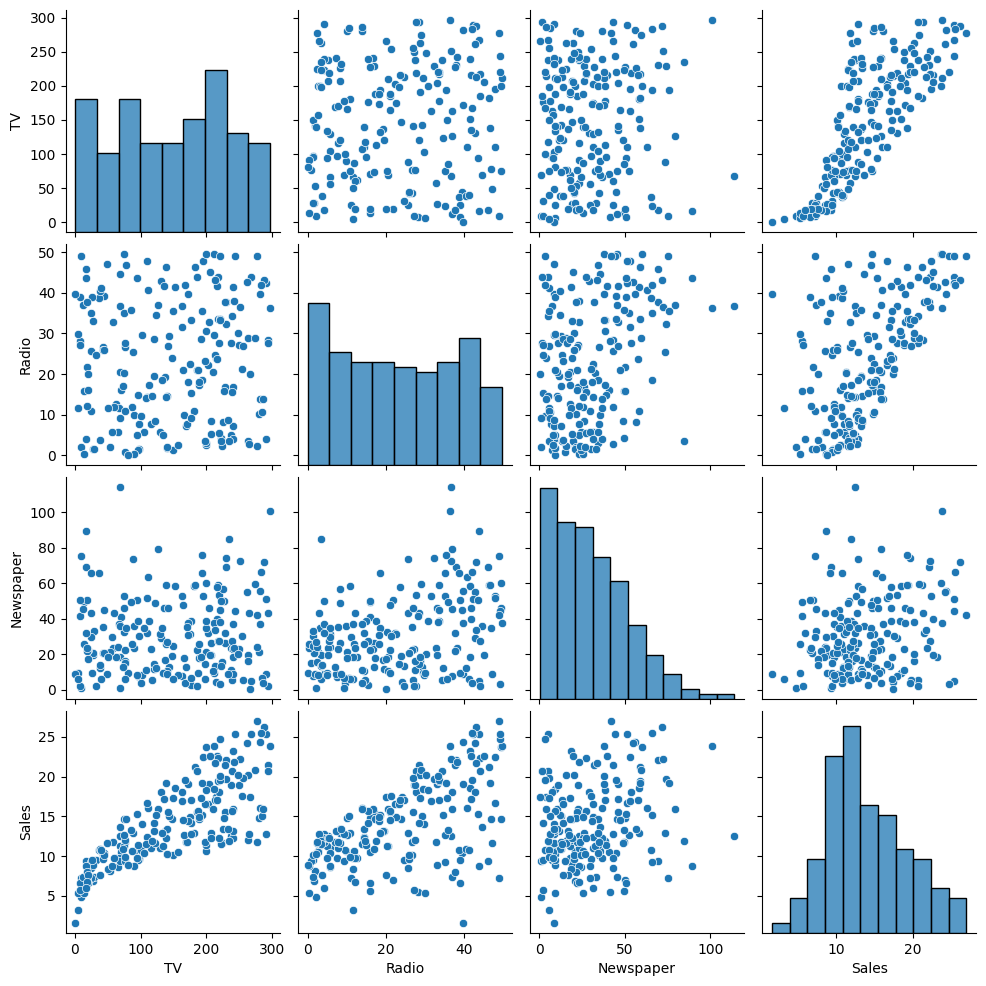

In [ ]:
import seaborn as sns
sns.pairplot(advertising)

Text(0, 0.5, 'Sales')

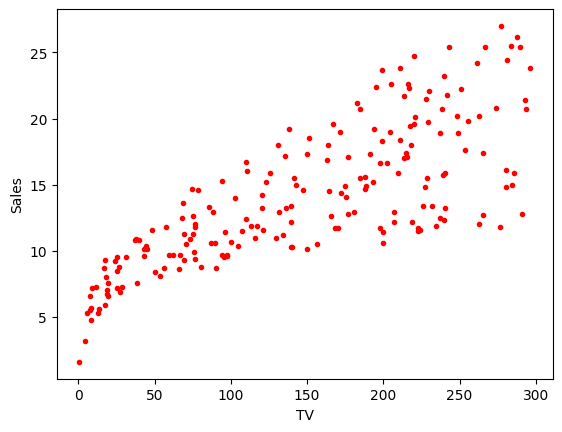

In [ ]:
plt.plot(advertising['TV'], advertising['Sales'], 'r.')
plt.xlabel("TV")
plt.ylabel("Sales")

### <font color='blue'>Estimating the Coefficients</font>
Our goal is to obtain coefficient estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ such that the linear model $Y = \hat{\beta_0} + \hat{\beta_1}X_1$ fits the available data well.

The measure of *closeness* we use here is the **least squares** criterion. *(What other approaches are available?)*

Suppose that we have a set of training data $\{(x_1, y_1), ..., (x_N, y_N)\}$. For coefficients $\beta = (\beta_0, \beta_1)$, define the **residual sum of squares (RSS)**:
$$\begin{align}
RSS(\beta) =& \sum_{i=1}^N (y_i - f(x_i))^2 \\
=& \sum_{i=1}^N\big(y_i - \beta_0 - \beta_1x_i\big)^2.
\end{align}$$

The least squares criterion means that we want to pick the coefficients $\hat{\beta} = (\hat{\beta}_0, \hat{\beta}_1)$ that minimizes $RSS$, i.e.,
$$\hat{\beta} = argmin_\beta RSS(\beta).$$

### <font color='blue'>Calculate the minimizer</font>
A necessary condition for the minimizer is that all of its partial derivates are zero.
$$\begin{align}
\frac{\partial RSS}{\partial \beta_0} =& -2 \sum_{i=1}^N\big(y_i - \beta_0 - \beta_1x_i\big)\\
\frac{\partial RSS}{\partial \beta_1} =& -2 \sum_{i=1}^N x_i\big(y_i - \beta_0 - \beta_1x_i\big).
\end{align}$$
The solution is
$$\begin{align}
\hat{\beta}_1 =& \frac{\sum_{i=1}^N(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^N(x_i - \bar{x})^2}\\
\hat{\beta}_0 =& \bar{y} - \hat{\beta}_1\bar{x},
\end{align}$$
where $\bar{x} = \frac{1}{n}\sum_{i=1}^Nx_i$ and $\bar{y} = \frac{1}{n}\sum_{i=1}^Ny_i$ are the sample means.

**Question:** How do we know that this is the minimum, not a local maximum or a [saddle point](https://en.wikipedia.org/wiki/Saddle_point)?


**Answer:** Positive semi-definite Hessian Matrix

$$ H_f = \left[
\begin{array}{ccc}
\frac{\partial f}{\partial x_1^2} & \dots & \frac{\partial f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \\
\frac{\partial f}{\partial x_n \partial x_1} & \dots & \frac{\partial f}{\partial x_n \partial x_n}
\end{array}
\right]$$

**Question:** What happens when $n=1$? \
**Question:** What is the Hession for Linear Regression?

### <font color='blue'>Quick matrix calculus refresher </font>
$$\frac{\partial (Ax)}{\partial x} = A^T$$
$$\frac{\partial (x^T A)}{\partial x} = A$$
$$\frac{\partial (x^T x)}{\partial x} = 2x$$
$$\frac{\partial (x^T A x)}{\partial x} = Ax+A^T x$$

Let's write down the multivariate case in class now.


In [ ]:
# Find the regression fit tothe advertising data
from sklearn.linear_model import LinearRegression

model_slm = LinearRegression()
model_slm.fit(advertising[['TV']], advertising['Sales'])

LinearRegression()

In [ ]:
# Show parameter values
print('beta_0:', model_slm.intercept_)
print('beta_1:', model_slm.coef_)

beta_0: 7.032593549127693
beta_1: [0.04753664]


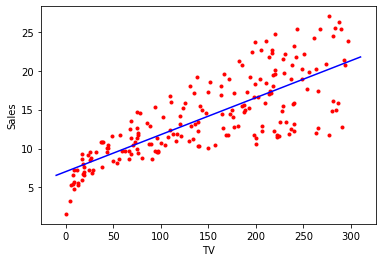

In [ ]:
# Plot the regression line
plt.plot(advertising['TV'], advertising['Sales'], 'r.')
plt.xlabel("TV")
plt.ylabel("Sales")
# Plot a regression line
beta0 = model_slm.intercept_
beta1 = model_slm.coef_[0]
x_coordinates = np.array([-10, 310])
y_coordinates = x_coordinates * beta1 + beta0
plt.plot(x_coordinates, y_coordinates, 'b-')

### <font color='blue'>The Plot of RSS</font>

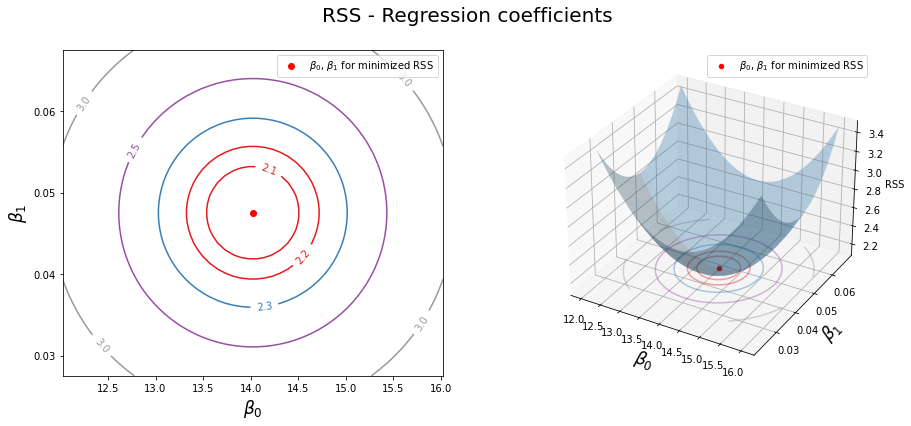

In [ ]:
plot_least_squares(df=advertising,x_name="TV",y_name="Sales")

### <font color='blue'>Observation: Estimates Depend on Data Set </font>

Let's look at fitting a linear regression with and without squared terms


In [ ]:
def plot_sample_regression(n=100,b0=2,b1=4,b2=0,sigma=20,fit_x2=False):
    """
    Plot linear regression line from model fit on random sample compared to fixed parameters
    Arg: n - number of random sample, b0 -intercept, b1 - slope, b2 - square term
    Returns: N/A - generate plot
    """
    x = np.random.uniform(-10, 10, n).reshape(-1, 1)
    x = np.concatenate([x,x*x],axis=1)

    y = b0 + b1 * x[:,0] + b2 * x[:,1] + np.random.randn(n) *sigma
    model = LinearRegression()
    x_plot = np.arange(-10, 10)
    y_true_plot = b0 + b1 * x_plot + b2 * (x_plot*x_plot)
    if fit_x2:
        model.fit(x,y)
        y_regr_plot = model.intercept_ + model.coef_[0] * x_plot + model.coef_[1] * (x_plot*x_plot)
    else:
        model.fit(x[:,0].reshape(n, -1), y)
        y_regr_plot = model.intercept_ + model.coef_[0] * x_plot


    plt.plot(x[:,0], y, 'go')
    plt.plot(x_plot, y_true_plot, 'r-', label="Y = {} + {}X + {} X^2".format(b0,b1,b2))
    plt.plot(x_plot, y_regr_plot, 'b-', label='Regression Line')
    plt.xlim([-10, 10])
    plt.legend()

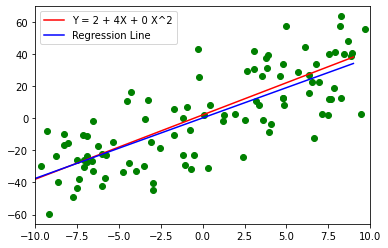

In [ ]:
plot_sample_regression()

### <font color='blue'>What about Model Complexity? </font>

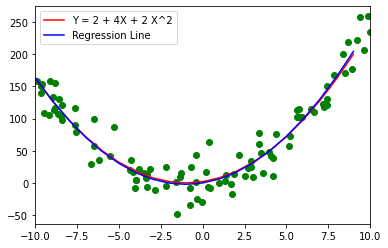

In [ ]:
plot_sample_regression(b2=2,fit_x2=True)

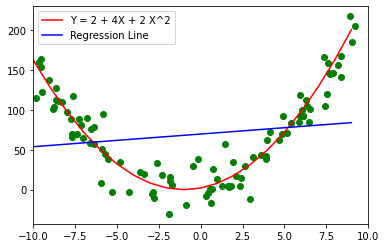

In [ ]:
plot_sample_regression(b2=2)

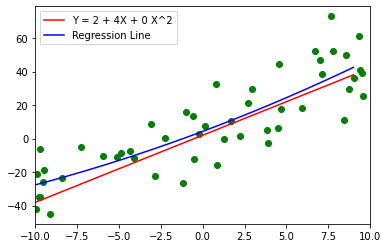

In [ ]:
plot_sample_regression(n=50,b2=0,fit_x2=True)

In [ ]:
from IPython.display import Image
Image(url='https://www.ncbi.nlm.nih.gov/books/NBK543534/bin/463627_1_En_8_Fig3_HTML.jpg')

#### See Appendix for deeper dive into statistical view on coefficients, variance of estimates, confidence intervals etc.

## 3. <font color='blue'>Gradient Descent, Stochastic Gradient Descent, and Mini-batch Gradient Descent </font>

In class on the board

Takeaways
- If data not too large, you can calculate closed form solution in some cases (e.g. linear model) and this may or may not be desirable
- More broadly, one can select a learning rate and use Gradient Descent
- Full gradient decent may be too large to compute
- To speed up Stochastic Gradient Descent and Mini-batch Gradient Descent are used
- Stochastic Gradient Descent may be too volitile
- Mini-batch Gradient Descent can create a nice balance
- Extensions: momentum methods

## 4. <font color='blue'>Loss vs Metric </font>
Discussed in class and slides

## 5. <font color='blue'>Performance Measures </font>
Discussed in class

## <font color='blue'>Appendix for Deeper Dive into Statistics of Linear Regression </font>

### <font color='blue'>Accessing the Accuracy of the Coefficient Estimates</font>

To access the accuracy, we need to refine our model:
$$Y = f(X) + \epsilon = \beta_0 + \beta_1 X + \epsilon.$$
- Here $\epsilon$ is a mean-zero random error term (model bias, unobservable variables, measuring errors).
- We assume that $\epsilon$ is independent of $X$.
- We assume that the variance of $\epsilon$ is $Var(\epsilon) = \sigma^2$.

Because of the existence of the random error, $y_i$'s are now considered as random variables.
- We assume that $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i$ is independent of $x_i$ with $E[\epsilon_i]=0$ and $Var(\epsilon_i)=\sigma^2$.

**Question:**
- What is $E[y_i]$? ($i=1,...,N$)
- What is $Var[y_i]$?
- What is $E[\bar{y}]$?
- What is $Var[\bar{y}]$?

### <font color='blue'>Variance of the Estimates</font>
$$Var(\hat{\beta}_0) = \frac{\sigma^2\sum_{i=1}^nx_i^2}{N\sum_{i=1}^N(x_i - \bar{x})^2}$$
$$Var(\hat{\beta}_1) = \frac{\sigma^2}{\sum_{i=1}^N(x_i - \bar{x})^2}$$
(Proof is postponed.)

In general, $\sigma^2$ is not known, but it can be estimated by **residual standard error (RSE)**
$$RSE(\hat{\beta})^2 = \frac{\sum_{i=1}^N(y_i - \hat{\beta}_0 - \hat{\beta}_1x_i)^2}{N-2} = \frac{RSS(\hat{\beta})}{N-2}.$$

The denominator is chosen as $n-2$ because it is an unbiased estimate of $\sigma^2$:

**Theorem.** $E\big[RSE(\hat{\beta})^2\big] = \sigma^2$. (Proof is postponed.)

### <font color='blue'>Confidence Intervals</font>
Variances of coefficent estimates can be used to compute **confidence intervals**. A 95% confidence interval is defined as a range of values such that with 95% probability, the range will contain the true unknown value of the parameter.

If we assume that **the error $\epsilon$ is a Gaussian random variable with expectation zero and variance $\sigma^2$**, then the 95% confidence interval for $\beta_1$ approximated takes for form
$$[\hat{\beta}_1 + 2\sqrt{Var(\hat{\beta}_1)}, \hat{\beta}_1 - 2\sqrt{Var(\hat{\beta}_1)}].$$
Similarly, a 95% confidence interval for $\beta_0$ approximately takes the form
$$[\hat{\beta}_0 + 2\sqrt{Var(\hat{\beta}_0)}, \hat{\beta}_0 - 2\sqrt{Var(\hat{\beta}_0)}].$$

[0.04753664]
7.032593549127693
RSE_squared: 10.618841328946221
Var(beta_0): 0.20962015795826405
Var(beta_1): 0.0000072
Confidence interval for beta1: 0.042155426057426025 0.0529178548086135


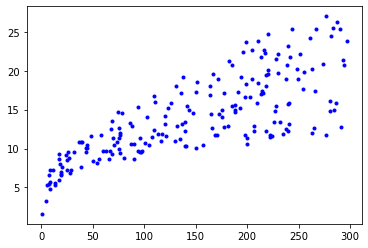

In [ ]:
# Calculate the 95% confidence interval for the advertising data
advertising.head()
# Here we focus on sales vs. TV
plt.plot(advertising['TV'], advertising['Sales'], 'b.')
print(model_slm.coef_)
print(model_slm.intercept_)
# estimate \sigma^2
beta0 = model_slm.intercept_
beta1 = model_slm.coef_[0]
# RSE^2
RSE_squared = np.sum((advertising['Sales'] - beta0 - beta1 * advertising['TV']) ** 2) / (len(advertising) - 2)
print("RSE_squared:", RSE_squared)
# Var(beta_0)
numerator = np.sum(advertising['TV'] ** 2) * RSE_squared
xbar = np.mean(advertising['TV'])
denominator = np.sum((advertising['TV'] - xbar)**2) * len(advertising)
var_beta0 = numerator / denominator
print("Var(beta_0):", var_beta0)
# Var(beta_1)
var_beta1 = RSE_squared / np.sum((advertising['TV'] - xbar) ** 2)
print("Var(beta_1): %.7f" % var_beta1)
upper_bound_beta1 = beta1 + 2 * np.sqrt(var_beta1)
lower_bound_beta1 = beta1 - 2 * np.sqrt(var_beta1)
print("Confidence interval for beta1:", lower_bound_beta1, upper_bound_beta1)

### <font color='blue'>Hypothesis Testing</font>
We can also perform **hypothesis test** on the coefficients. The most common hypothesis test involves testing the **null hypothesis** of

**$H_0$: There is no relationship between $X$ and $Y$**

versus the **alternative hypothesis**

**$H_a$: There is some relationship between $X$ and $Y$**

Mathematically, this corresponds to testing $H_0: \beta_1=0$ versus $H_a: \beta_1\neq 0$.

- To test the null hypothesis, we need to determine whether $\hat{\beta}_1$ is sufficiently far from zero.
- How far is enough? Then answer depends on the accuracy of $\hat{\beta}_1$.
- If $Var(\hat{\beta}_1)$ is small, then we only require small value to be confident that $\beta_1\neq 0$.
- In practice, we compute $t-statistic$
$$t = \frac{\hat{\beta}_1}{\sqrt{Var(\hat{\beta}_1)}}$$
- For $N>30$, the distribution of t-statistic is quite similar to the normal distribution. The conditional probability
$$Pr(t = \frac{\hat{\beta}_1}{\sqrt{Var(\hat{\beta}_1)}} | \beta_1 = 0)$$
is call the **p-value**. If the p-value is "small enough", we can conclude that the null hypothesis is unlikely to be true, and thus reject the null hypothesis.

In [ ]:
# Assess coefficient estimates
import statsmodels.formula.api as smf
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### <font color='blue'>Assessing the Accuracy of the Model</font>
Once we have rejected the null hypothesis $\beta_1=0$, it is natural to want to quantify how well the model fits the data. The quality of linear regression fit is typically assessed using two quantities: the **residual standard error (RSE)** and the **$R^2$ statistic**.

### <font color='blue'>Residual Standard Error</font>
The residual standard error measure the average amount that the true response deviates from the model prediction. The formula is given by (same as before)
$$RSE(\hat{\beta}) = \sqrt{\frac{\sum_{i=1}^N(y_i - \hat{y}_i)^2}{n-2}} = \sqrt{\frac{\sum_{i=1}^N(y_i - \hat{\beta}_0 - \hat{\beta}_1x_i)^2}{n-2}}.$$

**Question:** How do we interpret RSE?

![](https://blog.minitab.com/hubfs/Imported_Blog_Media/residual_illustration-1.gif)

In [ ]:
# Calculate the RSE of the advertising data
np.sqrt(np.sum((advertising['Sales'] - (model_slm.intercept_ + model_slm.coef_[0] * advertising['TV']))**2) / (len(advertising) - 2))

3.2586563686504624

<AxesSubplot:>

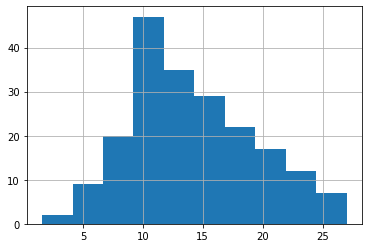

In [ ]:
advertising['Sales'].hist()

### <font color='blue'>$R^2$ Statistic</font>
The $R^2$ statistic evaluates the model in form of a proportion:
$$R^2 = 1 - \frac{RSS}{TSS} = 1 - \frac{\sum_{i=1}^N(y_i - \hat{y}_i)^2}{\sum_{i=1}^N(y_i - \bar{y})^2.}$$
Here **TSS** means the **total sum of squares**
**Question:** How do we interpret $R^2$?

In [ ]:
from sklearn.metrics import r2_score
Sales_pred = model_slm.predict(advertising['TV'].values.reshape(-1, 1))
r2_score(advertising['Sales'], Sales_pred)

0.611875050850071

### <font color='blue'>Discussion</font>
1. Is `TV` a useful feature in predicting `sales`?
2. How well does the model fit the data?
3. What prediction can we provide given a value for `TV`?